# STDSR23 - Assignment-01

> By Leila Khaertdinova, B21-DS-02

> My telegram alias: @leila1kh



# Quantile implementation

February 2023


> Reference: the research paper titled ["A Survey of Approximate Quantile Computation on Large-Scale Data"](https://arxiv.org/pdf/2004.08255.pdf)


## Implementation

The MRL98 Algorithm implementation:

In [ ]:
from sys import getsizeof

class Buffer:
    """
    Class represents the buffer, used for the MRL98 algorithm. 

    It stores elements of each buffer and its corresponding weight.
    """
    def __init__(self):
        self.items = None
        self.weight = 0


class BasicQuantileAlgorithm:
    """
    Class respresents the MRL98 algorithm implementation.
    """

    def __init__(self, b, k, _input):
        """
        Initializer for an algorithm

        :param b: the amount of buffers
        :param k: size of one buffer
        :param _input: input elements
        """
        self.total_w = None  # sum of all buffer weights
        self.seq = None  # terminating sequence of elements
        self.b = b  # the amount of buffers
        self.k = k  # the amount of elements in one buffer
        self.input_data = _input  # input dataset
        self.buffers = [Buffer() for _ in range(self.b)]  # array of b buffers
        self.pos = 0  # current position of the element from dataset

    def new(self, empty_buffer, elements):
        """
        This method populates the empty buffer with k elements from the input 
        dataset and assigns weight = 1 to it. If less than k remaining elements
        become in the input dataset, the method adds an equal number of 
        +infinity, -infinity to the buffer. 

        :param empty_buffer: empty buffer
        :param elements: elements from the input dataset
        """
        empty_buffer.weight = 1

        if self.pos + self.k < len(self.input_data):
            empty_buffer.items = elements[self.pos: self.pos + self.k]
            self.pos += self.k
        else:
            empty_buffer.items = elements[self.pos: len(self.input_data)]
            self.pos = len(self.input_data)

            while len(empty_buffer.items) < self.k:
                if len(empty_buffer.items) % 2 == 0:
                    empty_buffer.items.append(float('inf'))
                else:
                    empty_buffer.items.append(float('-inf'))

    def collapse(self, buffers):
        """
        This method takes full buffers, produces the resulting buffer 
        with total weight of passing buffers and stores it in the first buffer. 
        All other buffers (except the first one) become empty ones.

        :param buffers: buffers to be collapsed
        """
        w_y = 0
        seq = []

        for i in range(len(buffers)):
            w_y += buffers[i].weight
            seq += buffers[i].items * buffers[i].weight

        seq.sort()

        if w_y % 2 != 0:
            offset = (w_y + 1) // 2
        else:
            offset = w_y // 2

        buffers[0].items = []
        for j in range(self.k):
            buffers[0].items.append(seq[j * w_y + offset])

        buffers[0].weight = w_y

        for i in range(1, len(buffers)):
            buffers[i].items = None
            buffers[i].weight = 0

    def output(self, buffers):
        """
        This method takes full buffers, updates total weight and
        produces the sorted sequence of elements from buffers taking 
        the weight of each buffer into account.

        :param buffers: buffers to be collapsed
        """
        self.total_w = 0
        self.seq = []

        for i in range(len(buffers)):
            if buffers[i].items is not None:
                self.total_w += buffers[i].weight
                self.seq += buffers[i].items * buffers[i].weight

        self.seq.sort()

    def compute_quantile(self, q):
        """
        This method computes the q-th quantile of the data stream using the 
        Alsabti, Ranka and Singh policy from MRL98 algorithm. It fills b/2 
        empty buffers invoking new and then perform collapse on them, repeat 
        it b/2 times and then invoke output on the resulting buffers.

        Finally, the method returns approximate q-th quantile of the input 
        dataset, which is the element of the obtained sequence (after invoking 
        output operation) in position [q * k * total_weights].

        :param q: quantile to compute
        :return: approximate q-th quantile of input dataset
        """

        if len(self.input_data) == 0:
            return None
        
        if q == 1:
            return self.input_data[-1]

        for i in range(self.b // 2):
            if self.pos == len(self.input_data):
                break
            new_buffers = []
            for j in range(i, self.b // 2 + i):
                if self.pos == len(self.input_data):
                    break
                self.new(self.buffers[j], self.input_data)
                new_buffers.append(self.buffers[j])

            self.collapse(new_buffers)

        self.output(self.buffers)

        position = int(q * self.k * self.total_w)
        return self.seq[position]

    def compute(self, q):
        """
        This method computes the q-th quantile.

        Hides implementation of compute_quantile().

        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        if not (0 <= q <= 1):
            raise ValueError(f'q must be in [0; 1]. Got {q}')

        return self.compute_quantile(q)

    def multi_compute(self, qs):
        """
        This method computes multiple q-th quantiles.

        :param qs: list of quantiles to compute,
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """

        return [self.compute(q) for q in qs]

    def compute_space(self):
        """
        This method is for calculating space consumption of the algorithm.

        Returns the space consumption in KB.
        """
        return getsizeof(self.buffers) / 1024

#### NumPy Quantile Computing Algorithm implementation:


In [ ]:
import numpy as np
from sys import getsizeof


class NumpyQuantileAlgorithm:
    """
    Example of quantile algorithm
    
    This algorithm implementation is based on the numpy.quantile. 
    """
    def __init__(self):
        """
        Initializer of the class. 
        
        It initializes self.data with empty list
        """
        self.data = []
    
    def add_item(self, item):
        """
        Adds an item to the existing data
        """
        self.data.append(item)
    
    def add_multiple_items(self, items):
        """
        Adds multiple items to the existing data
        """
        self.data += items
    
    def compute_quantile(self, q):
        """
        Compute the q-th quantile
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return np.quantile(self.data, q)
  
    def multi_compute(self, qs):
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return list(self.compute_quantile(qs))

    def compute_space(self):
        """
        Calculate the space consumption of the algorithm.

        Returns the space consumption in KB.
        """
        return getsizeof(self.data) / 1024

## Report on the MRL98



The MRL98 is a deterministic quantile algorithm that computes an approximate quantile of large datasets focusing on low memory consumption. It was introduced in a paper "Approximate Medians and other Quantiles in One Pass and with Limited Memory" by G. S. Manku, S. Rajagopalan, and B. G. Lindsay in 1998.

The algorithm uses **b** initially empty buffers each of which consists of **k** elements. Each buffer in the algorithm has a parameter **w** - a positive weight value assigned to it.
To get a closer look at how the algorithm flows, let us consider its 3 main operations:
1. **NEW** operation populates an empty buffer with elements from the input dataset and sets the buffer's weight to 1.
2. **COLLAPSE** takes some of the buffers as input and produces a buffer by collapsing input ones. New buffer's weight becomes equal to total weight of input buffers. Produced buffer is logically different from the input buffers but physically stores the space corresponding to one of them.
3. **OUTPUT** is invoked on the terminating subset of buffers. It takes some buffers as inputs and produces the sorted sequence. Finally, the quantile can be computed as the element of that sequence at a specific position.

There are different Collapse Policies that can be used to implement the MRL98 algorithm. In my implementation, I applied one of them called **Alsabti, Ranka and Singh policy** described in the paper. This approach combines 3 main operations mentioned above in the following way: 
1. Fill **b/2** empty buffers using NEW and then perform COLLAPSE on them.
2. Repeat first step **b/2** times.
3. Invoke OUTPUT on the resulting buffers. 


The following table for values b and k in Alsabti, Ranka and Singh policy (taken from the study) will be used for further comparison and tests:


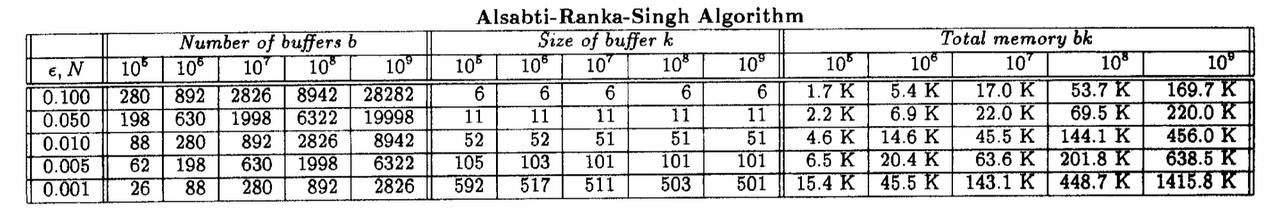

**Advantages of the MRL98 Algorithm:**


*   One-pass stream: The MRL98 algorithm computes results in a single pass over the dataset, making it a quite good candidate for applications where the stream cannot be fully stored in memory.
*   No requirements of inputs: the MRL98 does not require prior knowledge about the arrival or value distribution of its input datasets (except the dataset size).
*   Approximation guarantees: the algorithm provides explicit and tunable approximation guarantees.
*   Memory-efficient: the algorithm tries to a small amount of memory as possible.




**Disadvantages of the MRL98 Algorithm:**



*   Dataset size dependent: The MRL98 initially requires knowledge of the dataset's size. However, frequently enough, the size of the data is indeterminate and could possibly grow arbitrarily.
*   Accuracy limitations: The MRL98 algorithm provides the results that are less accurate than in other methods, especially for small approximation errors.





## The comparison of the time and space consumption



In [ ]:
import time
import random
import numpy
import matplotlib.pyplot as plt

In [ ]:
# find the time consumption of the algorithm
def calculate_time(algorithm, q):
    start = time.time()
    algorithm.compute_quantile(q)
    return time.time() - start

In [ ]:
# b, k values for e = 0.1 and fixed value of N from the table above
bk_values = {
    10**5: [(280, 6)],
    10**6: [(892, 6)],
    10**7: [(2826, 6)],
    10**8: [(8942, 6)]

    # 10**9: [(28282, 6)]
}

# the arbitrary q value
q = 0.5

In [ ]:
times_mrl = [] 
times_np = []

for n, bks in bk_values.items():
    for b, k in bks:
        # create a random dataset
        data = [random.randint(-10, 10) for _ in range(n)]  

        # run MRL98 on the random dataset and find time consumption
        mrl = BasicQuantileAlgorithm(b=b, k=k, _input=data)
        times_mrl.append(calculate_time(mrl, q))

        # run numPy algorithm on the random dataset and calculate the time 
        np_algo = NumpyQuantileAlgorithm()
        np_algo.add_multiple_items(data)
        times_np.append(calculate_time(np_algo, q))

In [ ]:
degrees = []

for n in bk_values.keys():
    degrees += [np.log10(n)] * len(bk_values[n])

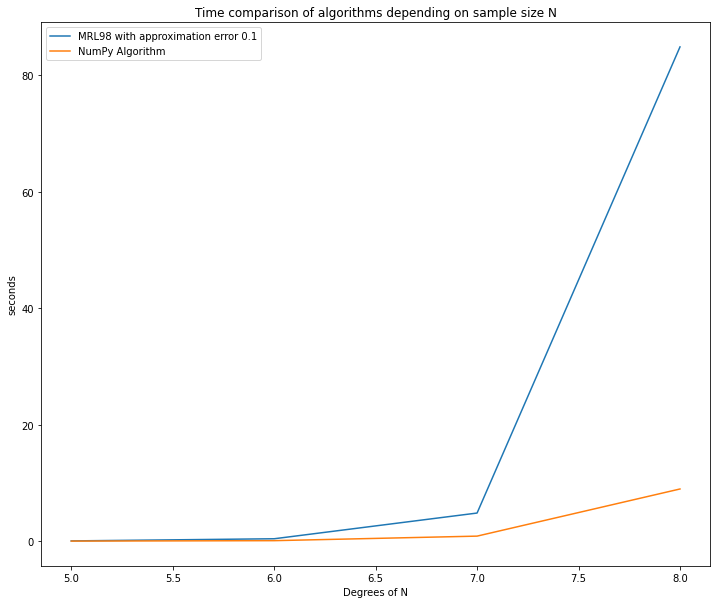

In [ ]:
plt.figure(figsize=(12, 10))

plt.plot(degrees, times_mrl, label='MRL98 with approximation error 0.1')

plt.title('Time comparison of algorithms depending on sample size N')
plt.plot(degrees, times_np, label='NumPy Algorithm')

plt.xlabel('Degrees of N')
plt.ylabel('seconds')
plt.legend(loc='best')

plt.show()
        

As can be seen from the plot above, the quantile computing algorithm using
NumPy runs faster than the MRL98 algorithm, as it is more efficient and resistant to large sample sizes  in terms of computation time. 



In [ ]:
space_mrl = [] 
space_np = []

for n, bks in bk_values.items():
    for b, k in bks:
        # create a random dataset
        data = [random.randint(-10, 10) for _ in range(n)]  

        # run MRL98 on the random dataset and find the occupied space 
        mrl = BasicQuantileAlgorithm(b=b, k=k, _input=data)
        mrl.compute_quantile(q)
        space_mrl.append(mrl.compute_space())

        # run numPy algorithm on the random dataset and find the occupied space 
        np_algo = NumpyQuantileAlgorithm()
        np_algo.add_multiple_items(data)
        np_algo.compute_quantile(q)
        space_np.append(np_algo.compute_space())


In [ ]:
print(space_mrl)
print(space_np)

[2.46875, 7.7890625, 23.1640625, 76.015625]
[879.0078125, 8789.1640625, 87890.7265625, 878906.3515625]


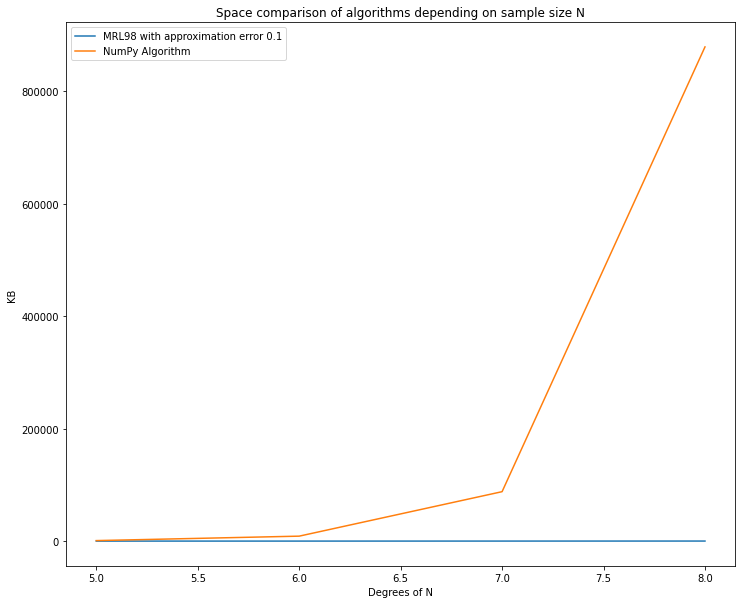

In [ ]:
plt.figure(figsize=(12, 10))

plt.plot(degrees, space_mrl, label='MRL98 with approximation error 0.1')

plt.title('Space comparison of algorithms depending on sample size N')
plt.plot(degrees, space_np, label='NumPy Algorithm')

plt.xlabel('Degrees of N')
plt.ylabel('KB')
plt.legend(loc='best')

plt.show()

As can be seen from the plot above, the MRL98 algorithm has a significantly lower space complexity compared to the Numpy quantile computing algorithm. This is due to the fact that the MRL98 algorithm does not store the whole dataset using limited number of buffers for this purpose, while the Numpy algorithm requires the entire dataset to be stored. As a result, the MRL98 algorithm is more efficient in terms of space consumption and can be used in situations when the storage space is limited.

## Test

Verify the correct implementation of the MRL98 algorithm by following testing steps:
1. Take `normal` distribution. Show, that with increase in sample size, quantiles calculated with your algorithms are become very close to the `inverse cdf` of the distribution. 

2. Perform the same experiment with any other continuous distribution (exponential, logistic, etc.)

In [ ]:
import numpy as np
from scipy.stats import norm, expon
import matplotlib.pyplot as plt

In [ ]:
# create plots 
def plot_ppfs(plots, row, rows=2):
    plt.figure(figsize=(23, 10), layout='constrained')
    for index, plot in enumerate(plots):
        plt.subplot(rows, len(plots), index + 1)
        true, mrl, quantiles, sample_size, distribution = plot
        plt.plot(quantiles, true, label=f'Inverse CDF ({distribution})')
        plt.plot(quantiles, mrl, label=f'Sample quantiles')
        plt.title(f'sample size = {sample_size}, {distribution} distribution')
        plt.legend()

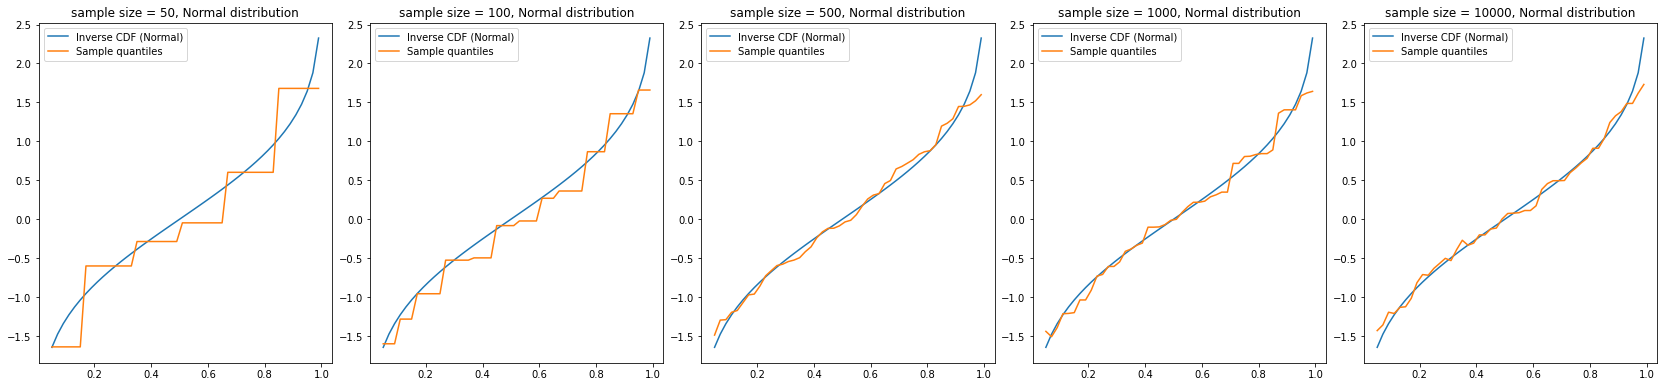

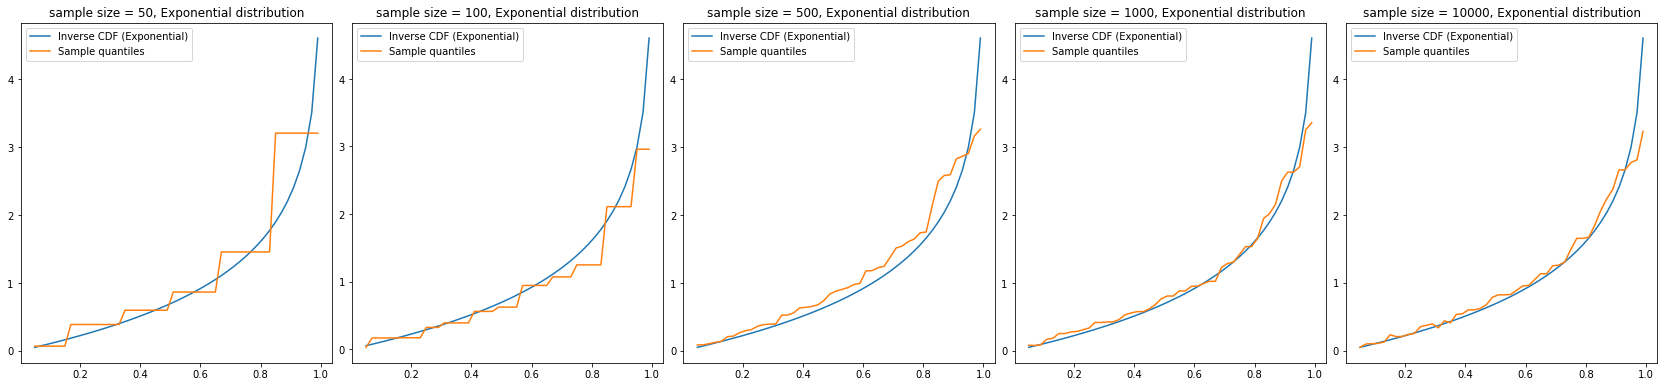

In [ ]:
b = 20
k = 6
   
# perform experiments with normal and continuous distributions
quantiles = np.arange(0.05, 1, 0.02)
sample_size_arr = [50, 100, 500, 1000, 10000]
for row, dist in enumerate(['Normal', 'Exponential']):
    plots = []
    for size_ in sample_size_arr:
        curr_q = []
        curr_inv_cdf = []
        if dist == 'Normal':
            curr_sample = list(np.random.normal(size=size_))
        elif dist == 'Exponential':
            curr_sample = list(np.random.exponential(size=size_))
        mrl = BasicQuantileAlgorithm(b=b, k=k, _input=curr_sample)
        for q in quantiles:
            curr_q.append(mrl.compute_quantile(q))
            if dist == 'Normal':
                curr_inv_cdf.append(norm.ppf(q))
            elif dist == 'Exponential':
                curr_inv_cdf.append(expon.ppf(q))
        
        plots.append((curr_inv_cdf, curr_q, quantiles, size_, dist))
    plot_ppfs(plots, row + 1)

As can be seen from the obtained results, when the normal and exponential distributions are taken as sample sizes increasing, the quantiles calculated with the MRL98 algorithm become very close to the inverse cumulative distribution function (CDF) of each distribution. 

## An experiment that shows the main purpose of the algorithm


The MRL98 algorithm is created especially for computing approximate quantiles of large datasets when memory is strictly limited. In the above part "Space consumption comparison with NumPy algorithm", the MRL98 algorithm has been shown to consume memory in a very efficient manner. Herewith, it provides quite good results compared to real ones. So, let us now check this:

In [ ]:
import random 
import matplotlib.pyplot as plt

MRL98 algoritm with N=1000000, error=0.1, b=7, k=54


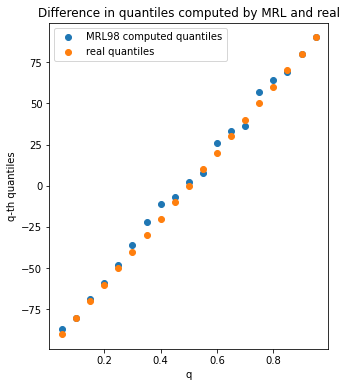

MRL98 algoritm with N=1000000, error=0.05, b=6, k=117


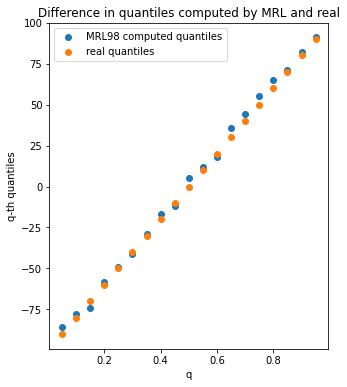

MRL98 algoritm with N=1000000, error=0.01, b=12, k=229


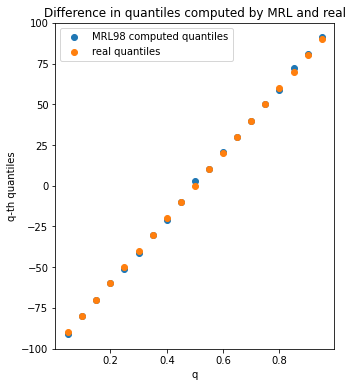

MRL98 algoritm with N=1000000, error=0.005, b=8, k=583


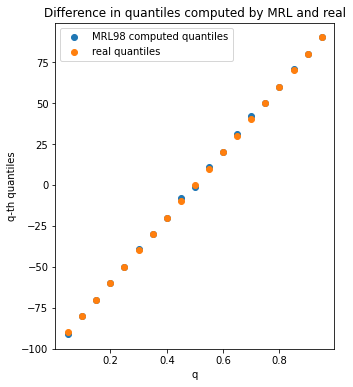

MRL98 algoritm with N=1000000, error=0.001, b=5, k=3031


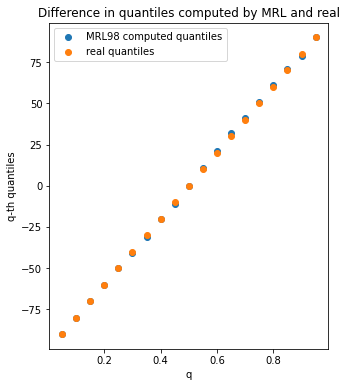

MRL98 algoritm with N=10000000, error=0.1, b=10, k=60


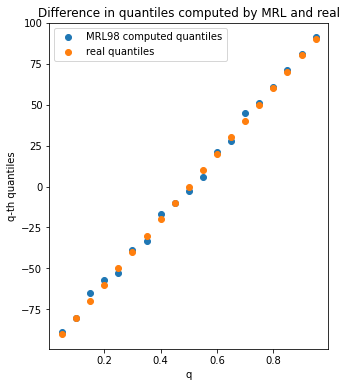

MRL98 algoritm with N=10000000, error=0.05, b=8, k=129


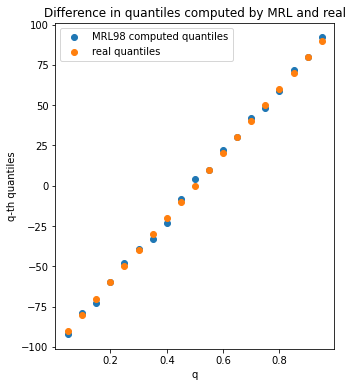

MRL98 algoritm with N=10000000, error=0.01, b=9, k=412


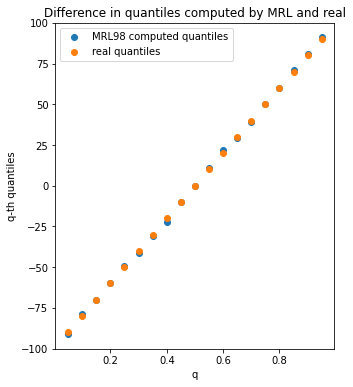

MRL98 algoritm with N=10000000, error=0.005, b=8, k=875


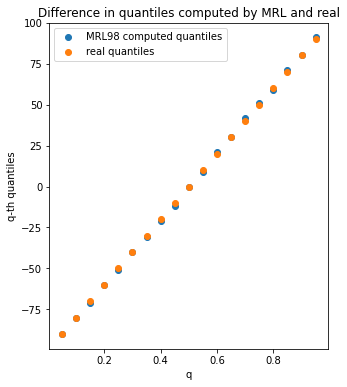

MRL98 algoritm with N=10000000, error=0.001, b=5, k=5495


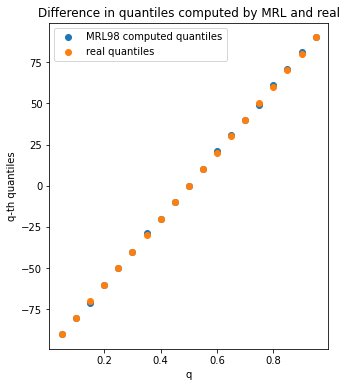

In [ ]:
bk_values = {
             (10**6, 0.1): (7, 54),
             (10**6, 0.05): (6, 117),
             (10**6, 0.01): (12, 229),
             (10**6, 0.005): (8, 583),
             (10**6, 0.001): (5, 3031),

             (10**7, 0.1): (10, 60),
             (10**7, 0.05): (8, 129),
             (10**7, 0.01): (9, 412),
             (10**7, 0.005): (8, 875),
             (10**7, 0.001): (5, 5495)}

quantiles = np.arange(0.05, 1, 0.05)

for (n, e), (b, k) in bk_values.items():
    real_q = []
    mrl_q = []
    print(f'MRL98 algoritm with N={n}, error={e}, b={b}, k={k}')
    # create a random dataset
    data = [random.randint(-100, 100) for _ in range(n)] 
    mrl = BasicQuantileAlgorithm(b=b, k=k, _input=data)

    np_algo = NumpyQuantileAlgorithm()
    np_algo.add_multiple_items(data)

    # calculate q-quantiles 
    for q in quantiles:
        mrl_q.append(mrl.compute_quantile(q))
        real_q.append(np_algo.compute_quantile(q))
   
    # plotting the results
    plt.figure(figsize=(5, 6))
    plt.scatter(quantiles, mrl_q, label='MRL98 computed quantiles')
    plt.scatter(quantiles, real_q, label='real quantiles')

    plt.xlabel('q')
    plt.ylabel('q-th quantiles')
    plt.title('Difference in quantiles computed by MRL and real')
    plt.legend(loc='best')
    plt.show()  
